In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [7]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [8]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [9]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [10]:
df_fullerton = pd.read_csv('cleaned_fullerton.csv')
df_parkroyal = pd.read_csv('cleaned_parkroyal-collection-marina-bay.csv')
df_pan = pd.read_csv('cleaned_pan-pacific.csv')
df_mbs = pd.read_csv('cleaned_mbs_total.csv')
df_swissotel = pd.read_csv('cleaned_swissotel-the-stamford.csv')


df_combi = pd.concat([df_fullerton, df_parkroyal, df_pan, df_mbs, df_swissotel])

In [11]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.append('fullerton')
sw.append('parkroyal')
sw.append('marina_bay')
sw.append('marina')
sw.append('swissotel')
sw.append('stamford')
sw.append('pan_pacific')
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nuzzul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/nuzzul/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stemmed

In [12]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['tokens'] = df_filtered['stem_review'].apply(preprocess)

In [13]:
df_precovid = df_filtered[df_filtered['covid'] == 'PreCovid']
df_postcovid = df_filtered[df_filtered['covid'] == 'PostCovid']

In [14]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [ ]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_precovid['tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [15]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [16]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [ ]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    post_ldamodel = lda(post_corpus, num_topics=i, id2word=post_dict, passes=15)
    
    postcovid_coherence = CoherenceModel(model=post_ldamodel, texts=df_postcovid['tokens'], dictionary=post_dict, coherence='c_v')
    lda_coherence = postcovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [17]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [18]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

In [19]:
topics_pre

[(0,
  [('stay', 0.061995853),
   ('hotel', 0.05966024),
   ('staff', 0.044601444),
   ('room', 0.040968098),
   ('great', 0.037337836),
   ('view', 0.02186429),
   ('excel', 0.019412592),
   ('help', 0.01899258),
   ('breakfast', 0.01476122),
   ('love', 0.013217276),
   ('would', 0.013121331),
   ('time', 0.012035675),
   ('recommend', 0.0115688555),
   ('club', 0.011443297),
   ('best', 0.011049095),
   ('good', 0.010650711),
   ('night', 0.010644153),
   ('well', 0.010265735),
   ('fantast', 0.010206412),
   ('comfort', 0.010030493)]),
 (1,
  [('room', 0.04343093),
   ('hotel', 0.028065328),
   ('check', 0.0266577),
   ('stay', 0.013891034),
   ('time', 0.012366528),
   ('get', 0.0104261115),
   ('one', 0.010378332),
   ('would', 0.009989528),
   ('us', 0.009557725),
   ('book', 0.009014975),
   ('staff', 0.008310673),
   ('like', 0.007843322),
   ('even', 0.007773048),
   ('night', 0.007668016),
   ('day', 0.0075510684),
   ('guest', 0.0071282024),
   ('wait', 0.0069622737),
   ('

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_14120\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


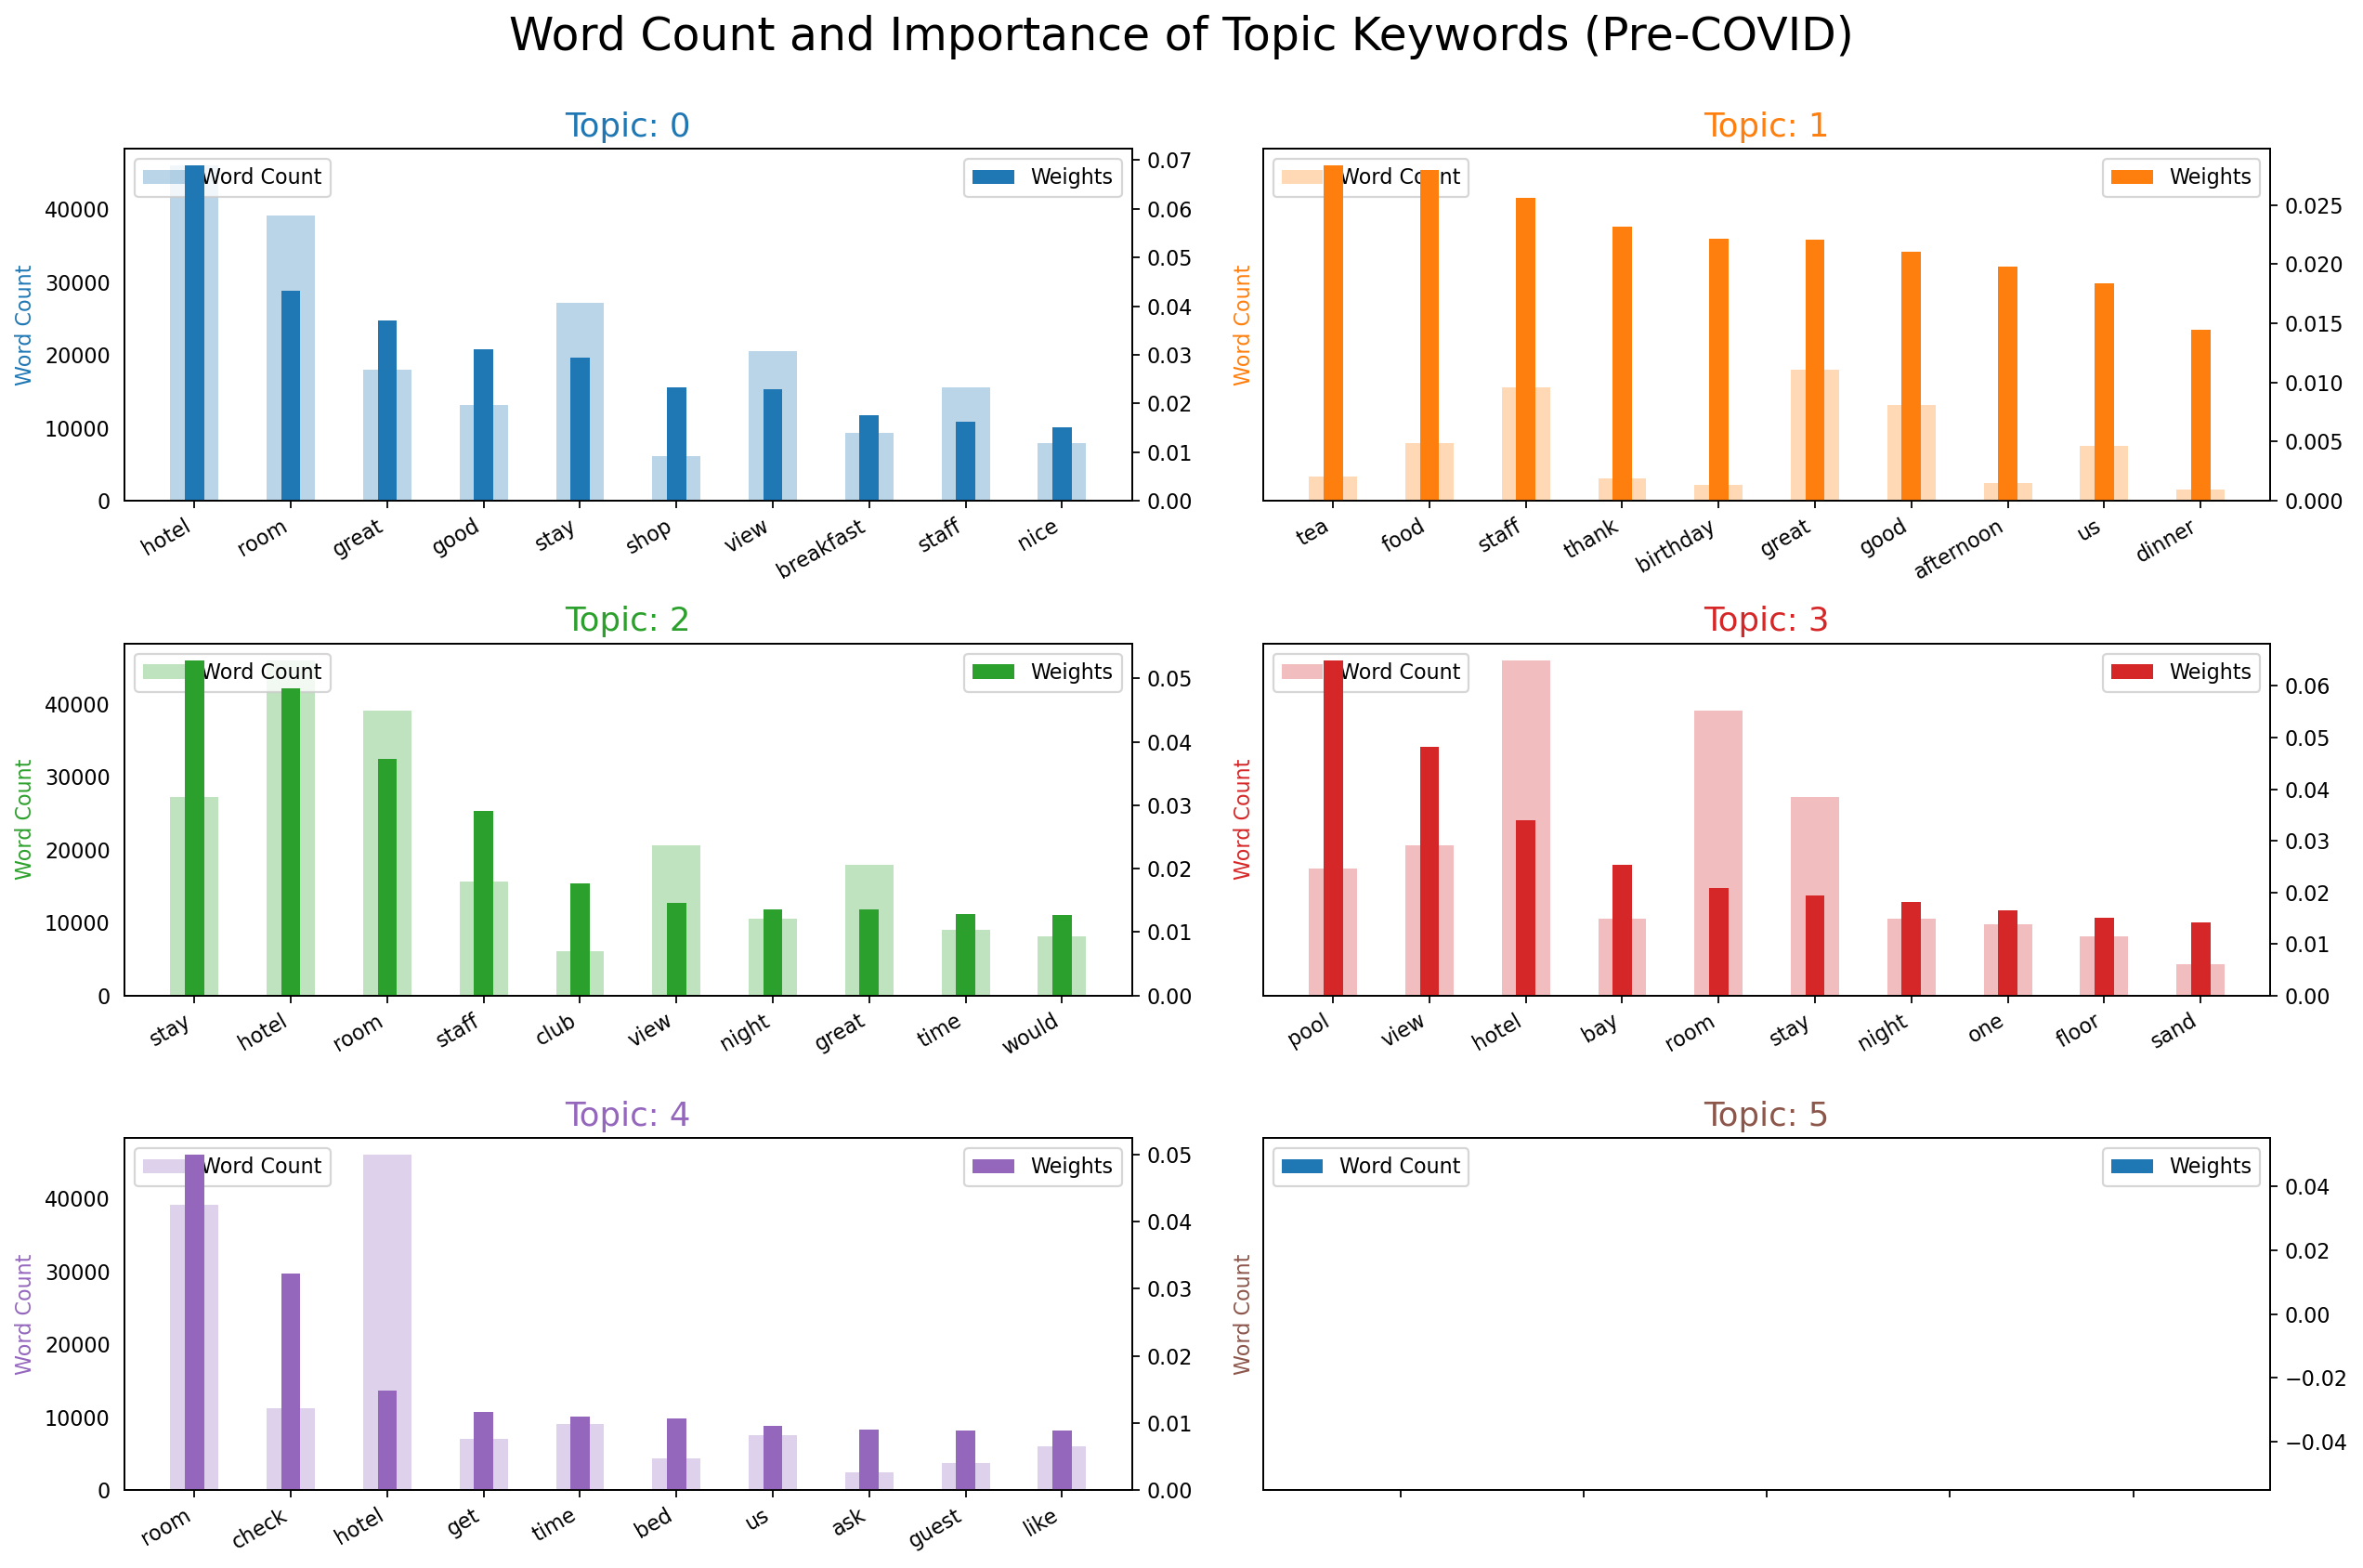

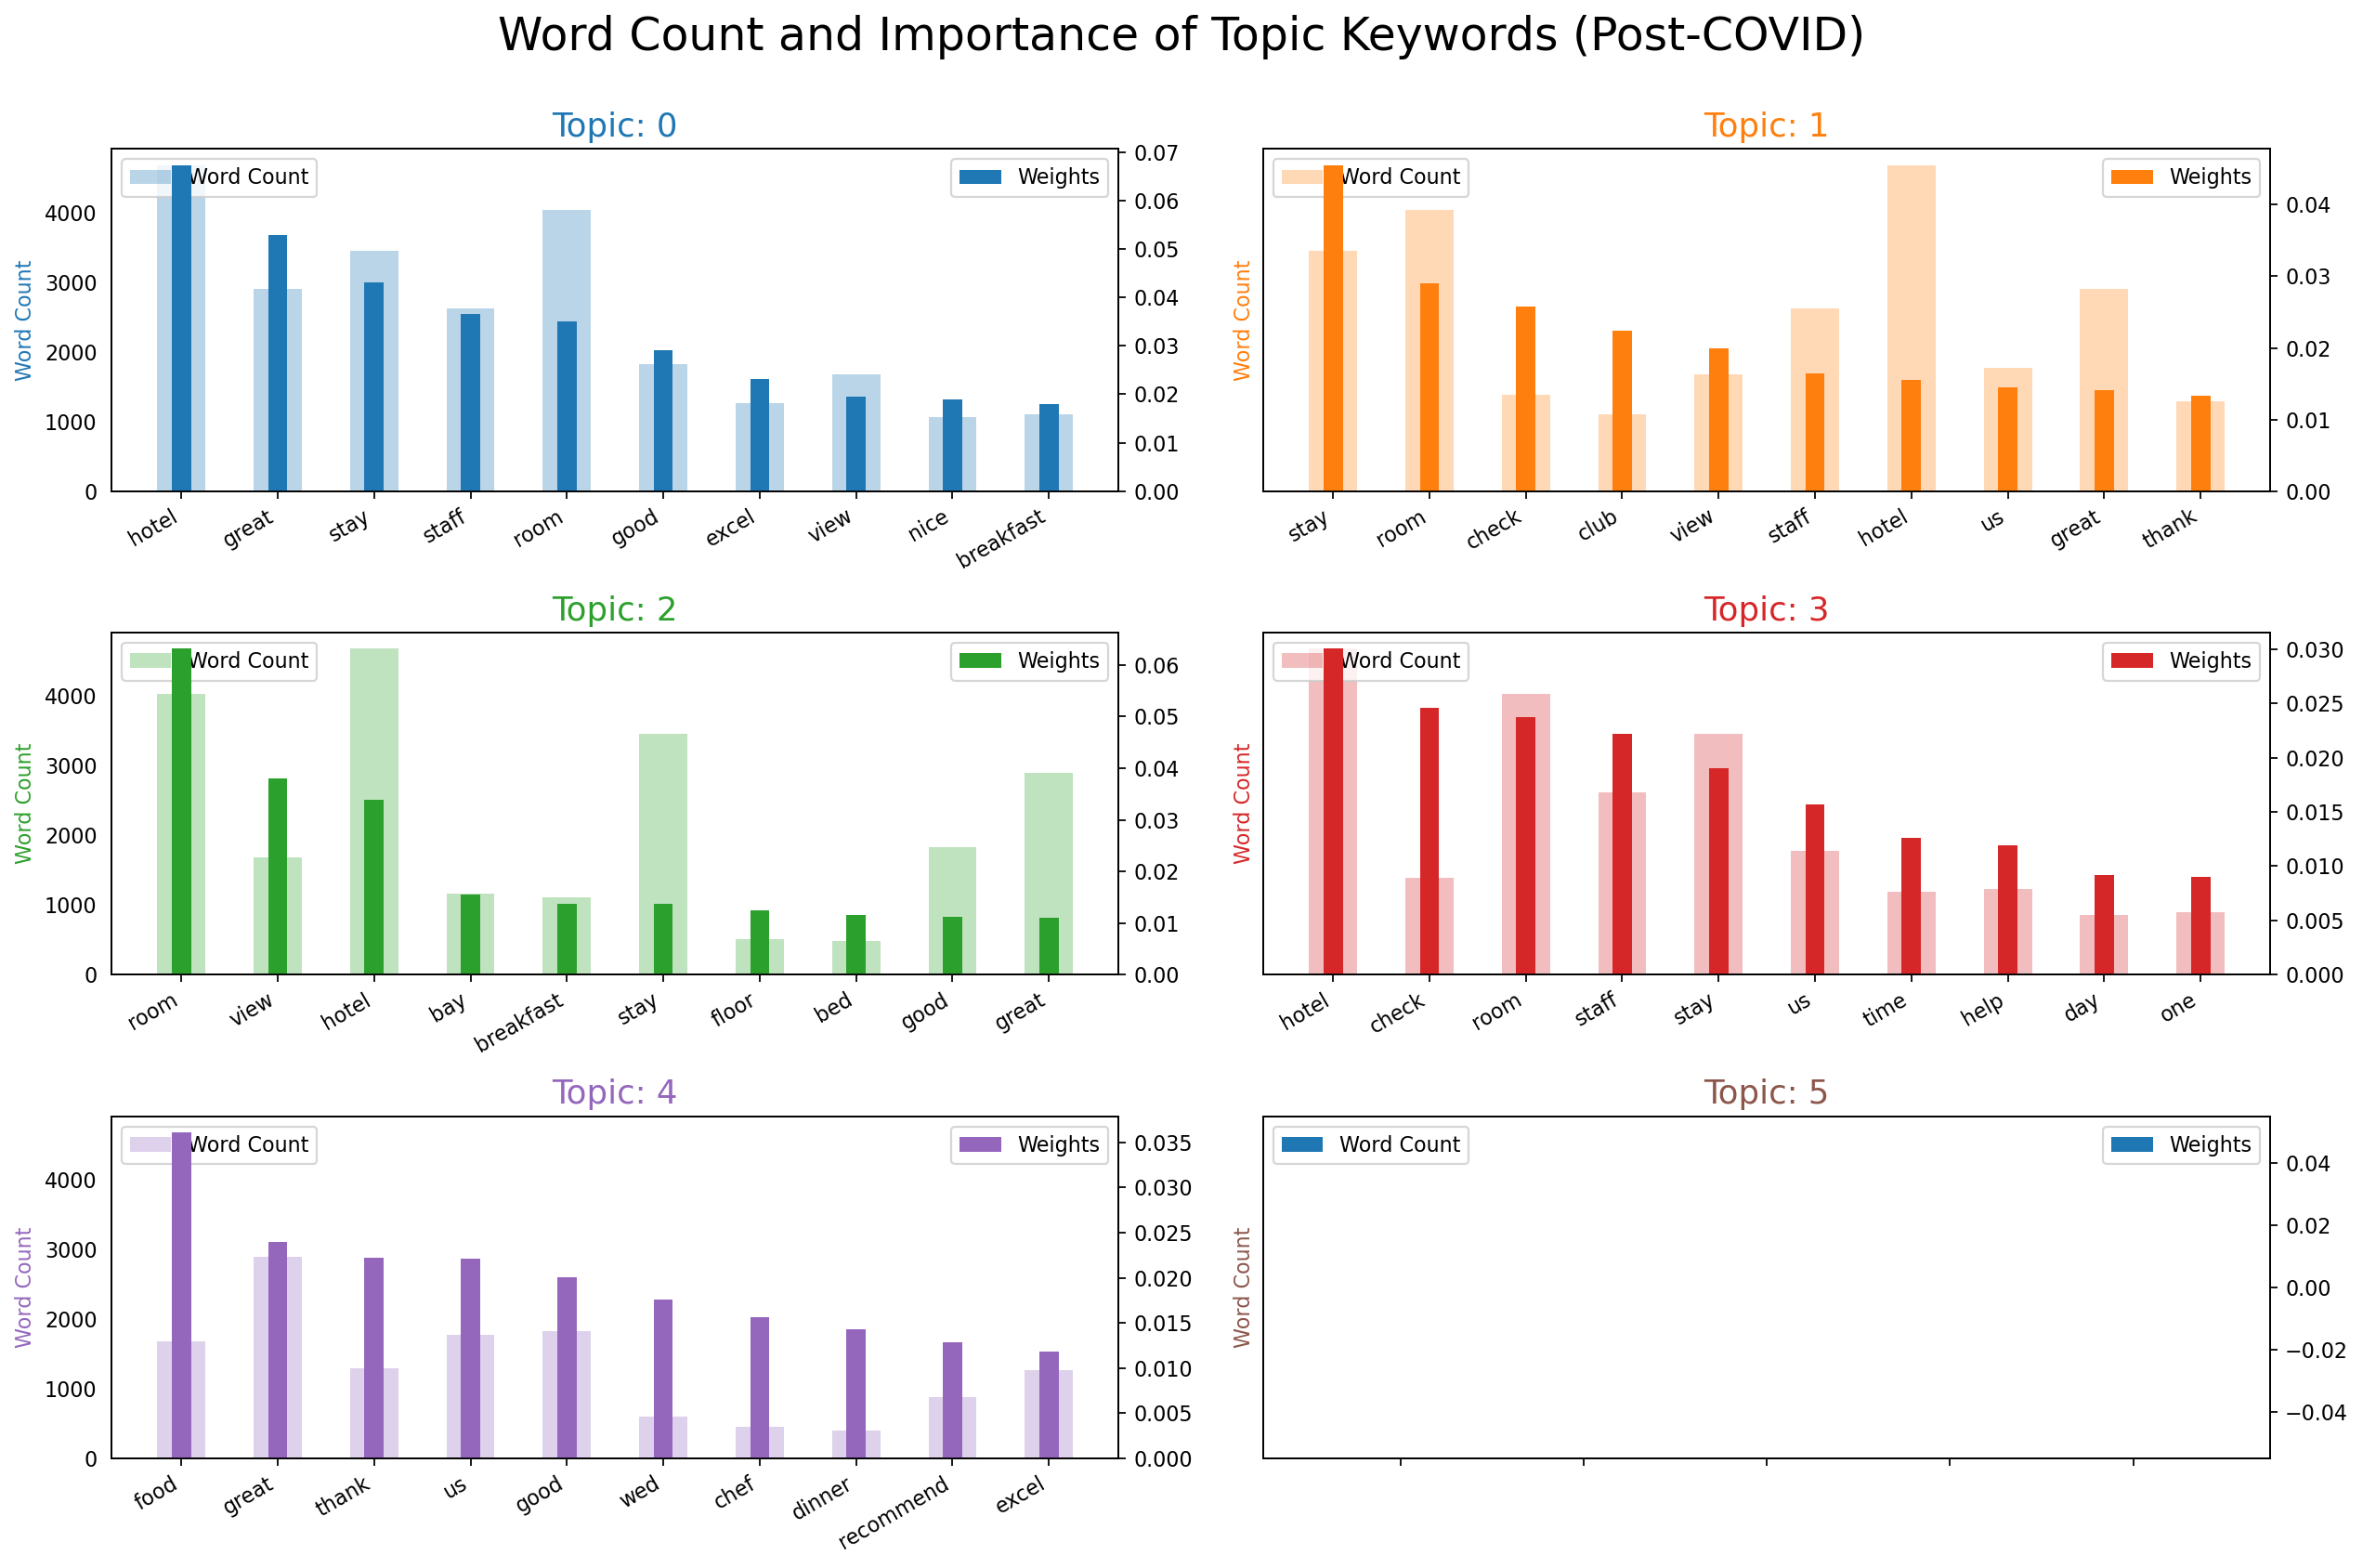

In [18]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

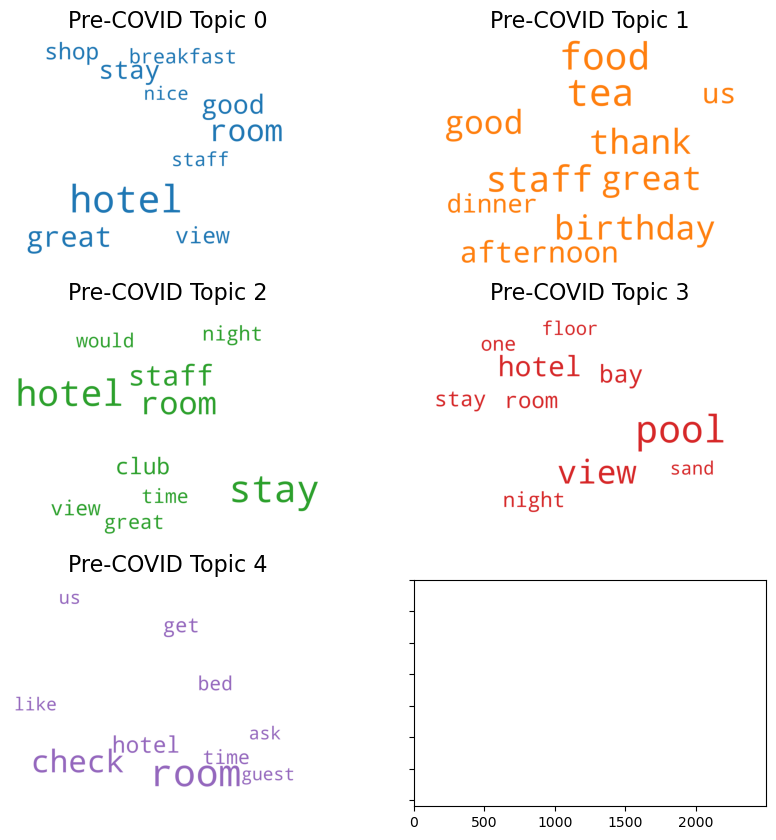

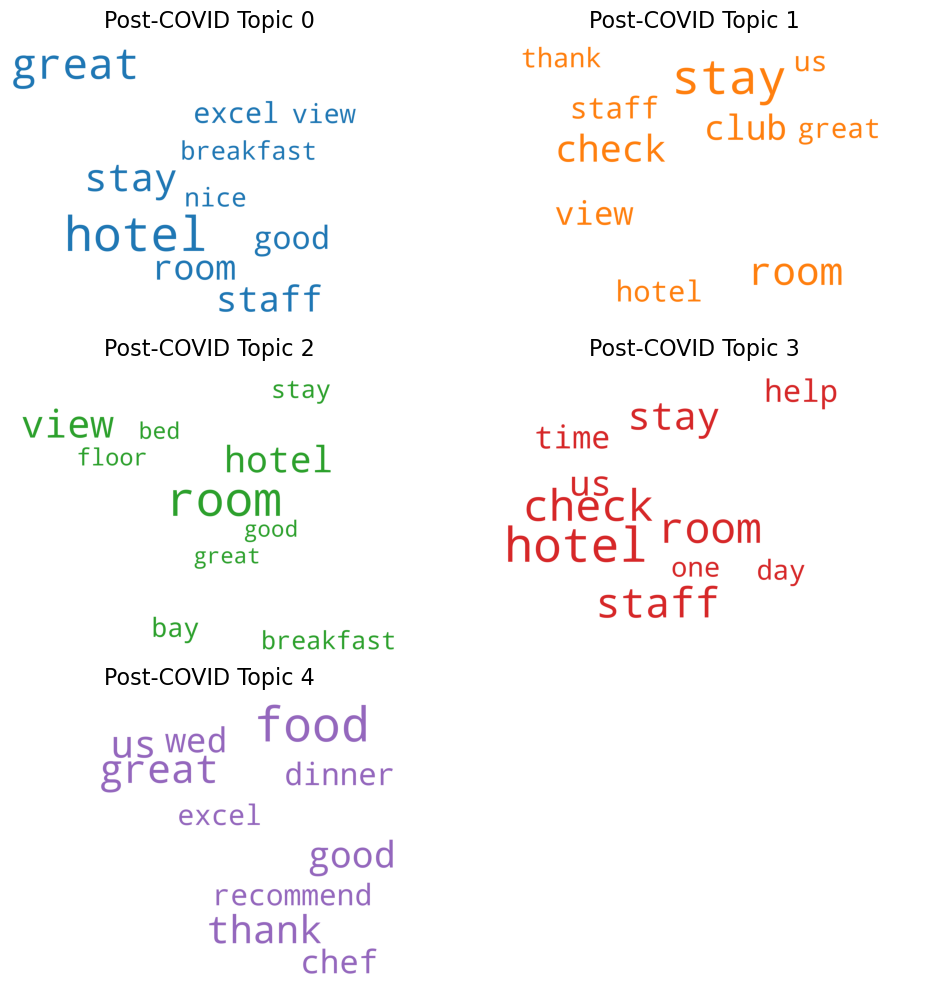

In [19]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [20]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [21]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [22]:
clean_precovid = df_precovid['stem_review'].apply(preprocess)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['stem_review'].apply(preprocess)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [23]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [24]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [25]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=5, id2word=post_dict, passes=15)

In [26]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

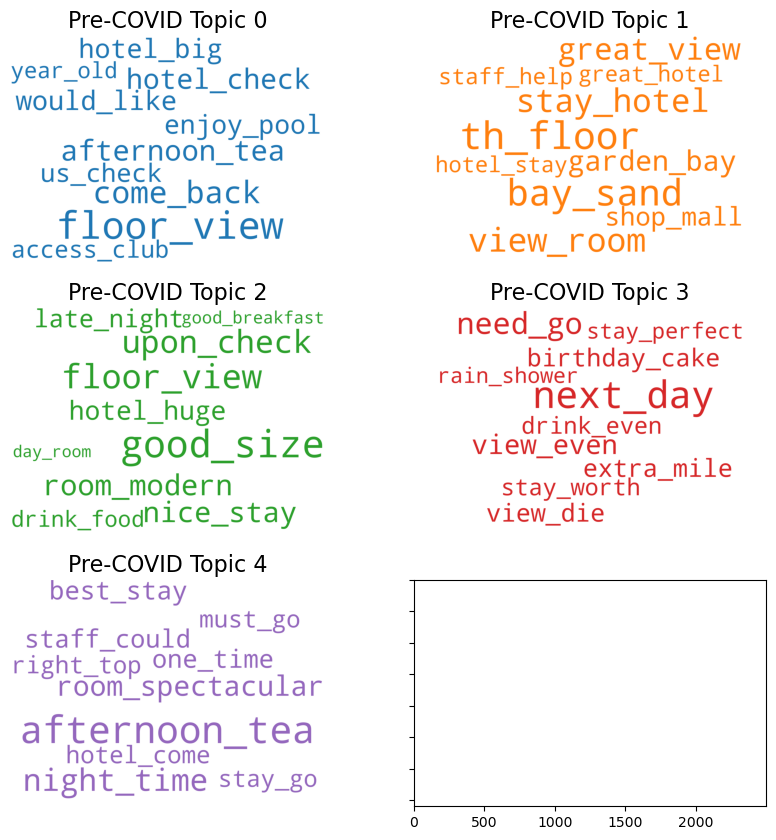

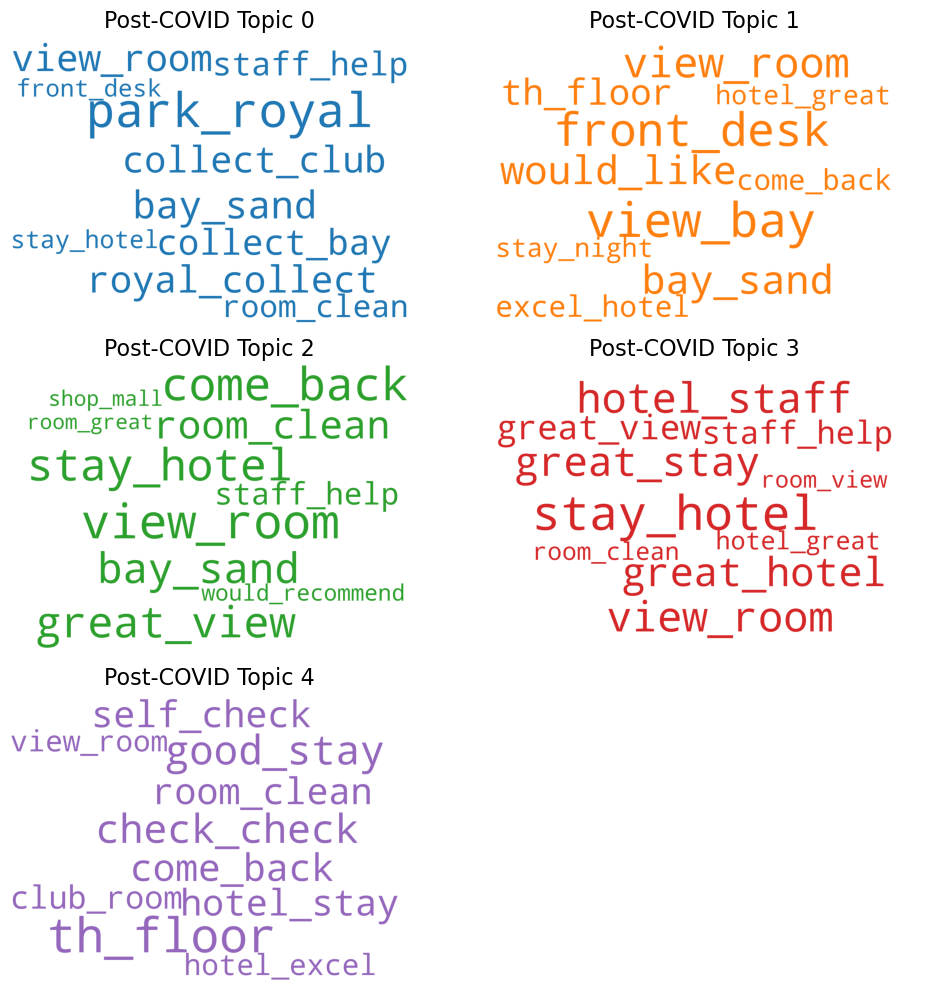

In [28]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [32]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [33]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['tokens'] = df_filtered['lem_review'].apply(preprocess)

In [34]:
df_precovid = df_filtered[df_filtered['covid'] == 'PreCovid']
df_postcovid = df_filtered[df_filtered['covid'] == 'PostCovid']

In [35]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_precovid['tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_precovid['tokens']]

In [36]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_precovid['tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.36177161374101
The coherence score at topic 3 is 0.35945139341308524
The coherence score at topic 4 is 0.3707588108286838
The coherence score at topic 5 is 0.39867767895943096
The coherence score at topic 6 is 0.40020929817275147


In [39]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=6, id2word=pre_dict, passes=15)

In [37]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(df_postcovid['tokens'])
post_corpus = [post_dict.doc2bow(text) for text in df_postcovid['tokens']]

In [38]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    post_ldamodel = lda(post_corpus, num_topics=i, id2word=post_dict, passes=15)
    
    postcovid_coherence = CoherenceModel(model=post_ldamodel, texts=df_postcovid['tokens'], dictionary=post_dict, coherence='c_v')
    lda_coherence = postcovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.35237028032012885
The coherence score at topic 3 is 0.36322993750989613
The coherence score at topic 4 is 0.34938764435749675
The coherence score at topic 5 is 0.3846869748463673
The coherence score at topic 6 is 0.39053214816400056


In [40]:
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=6, id2word=post_dict, passes=15)

In [41]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_precovid['tokens'] for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in df_postcovid['tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_14120\2307337869.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


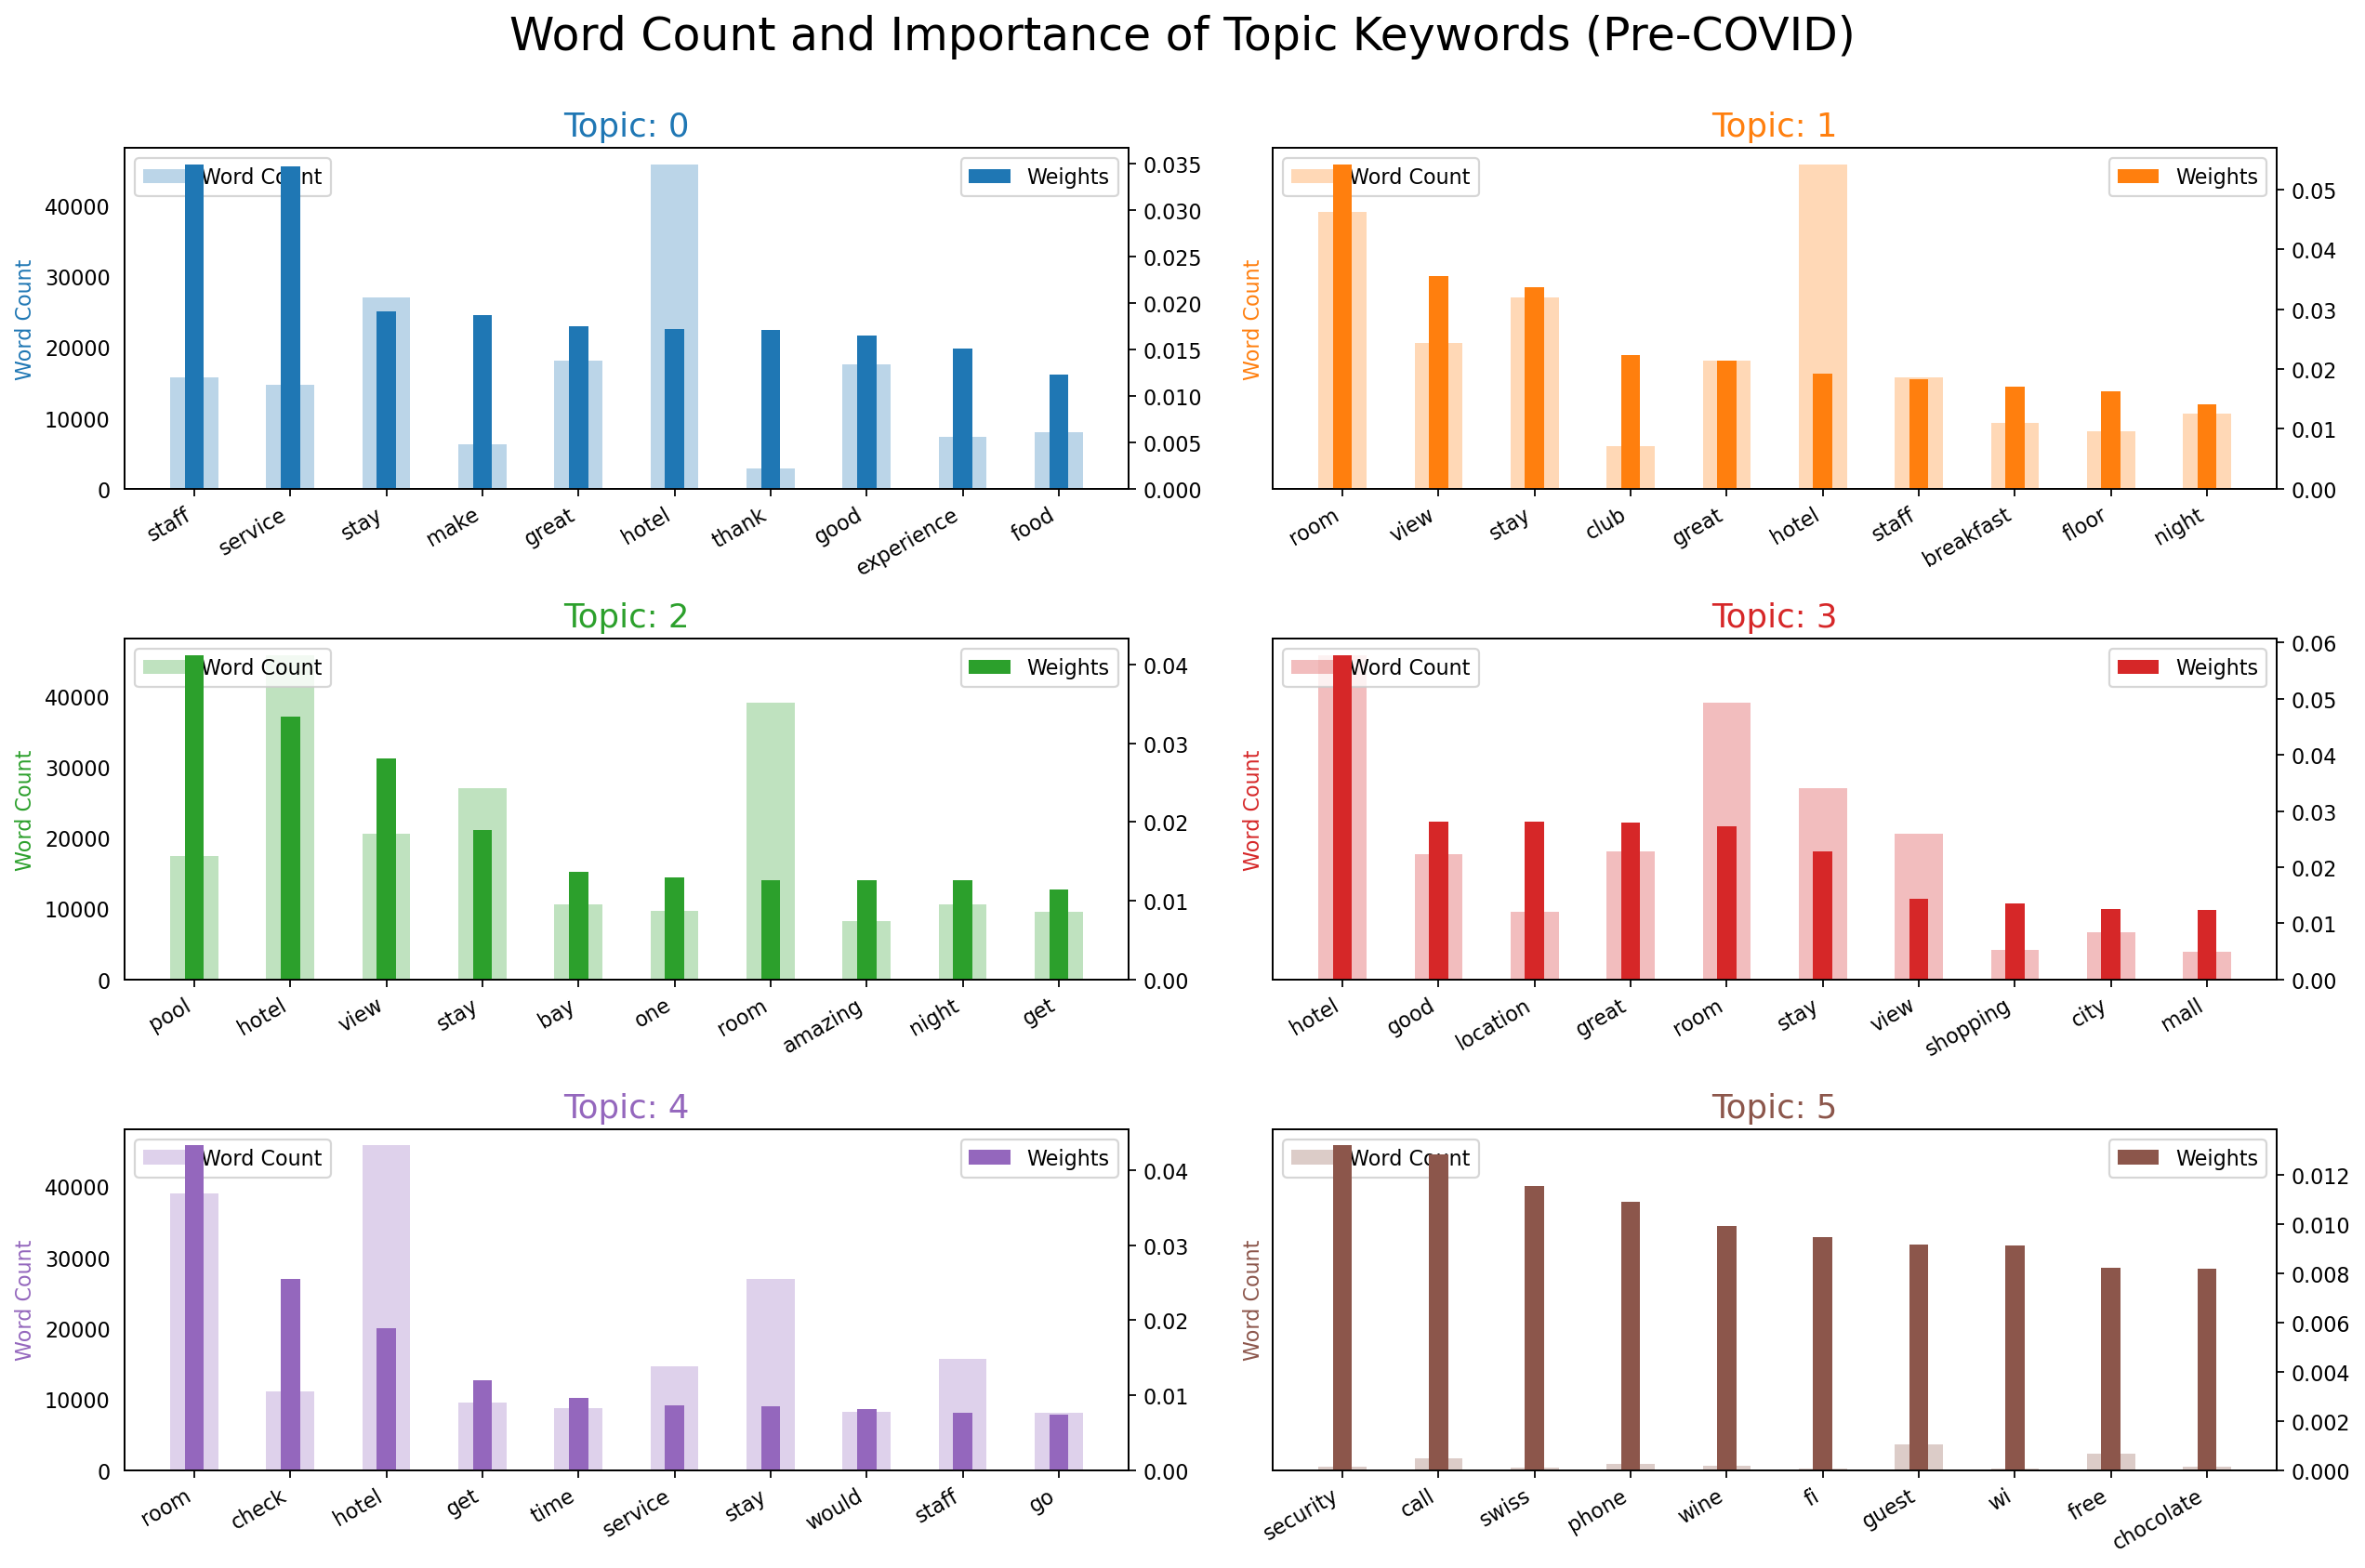

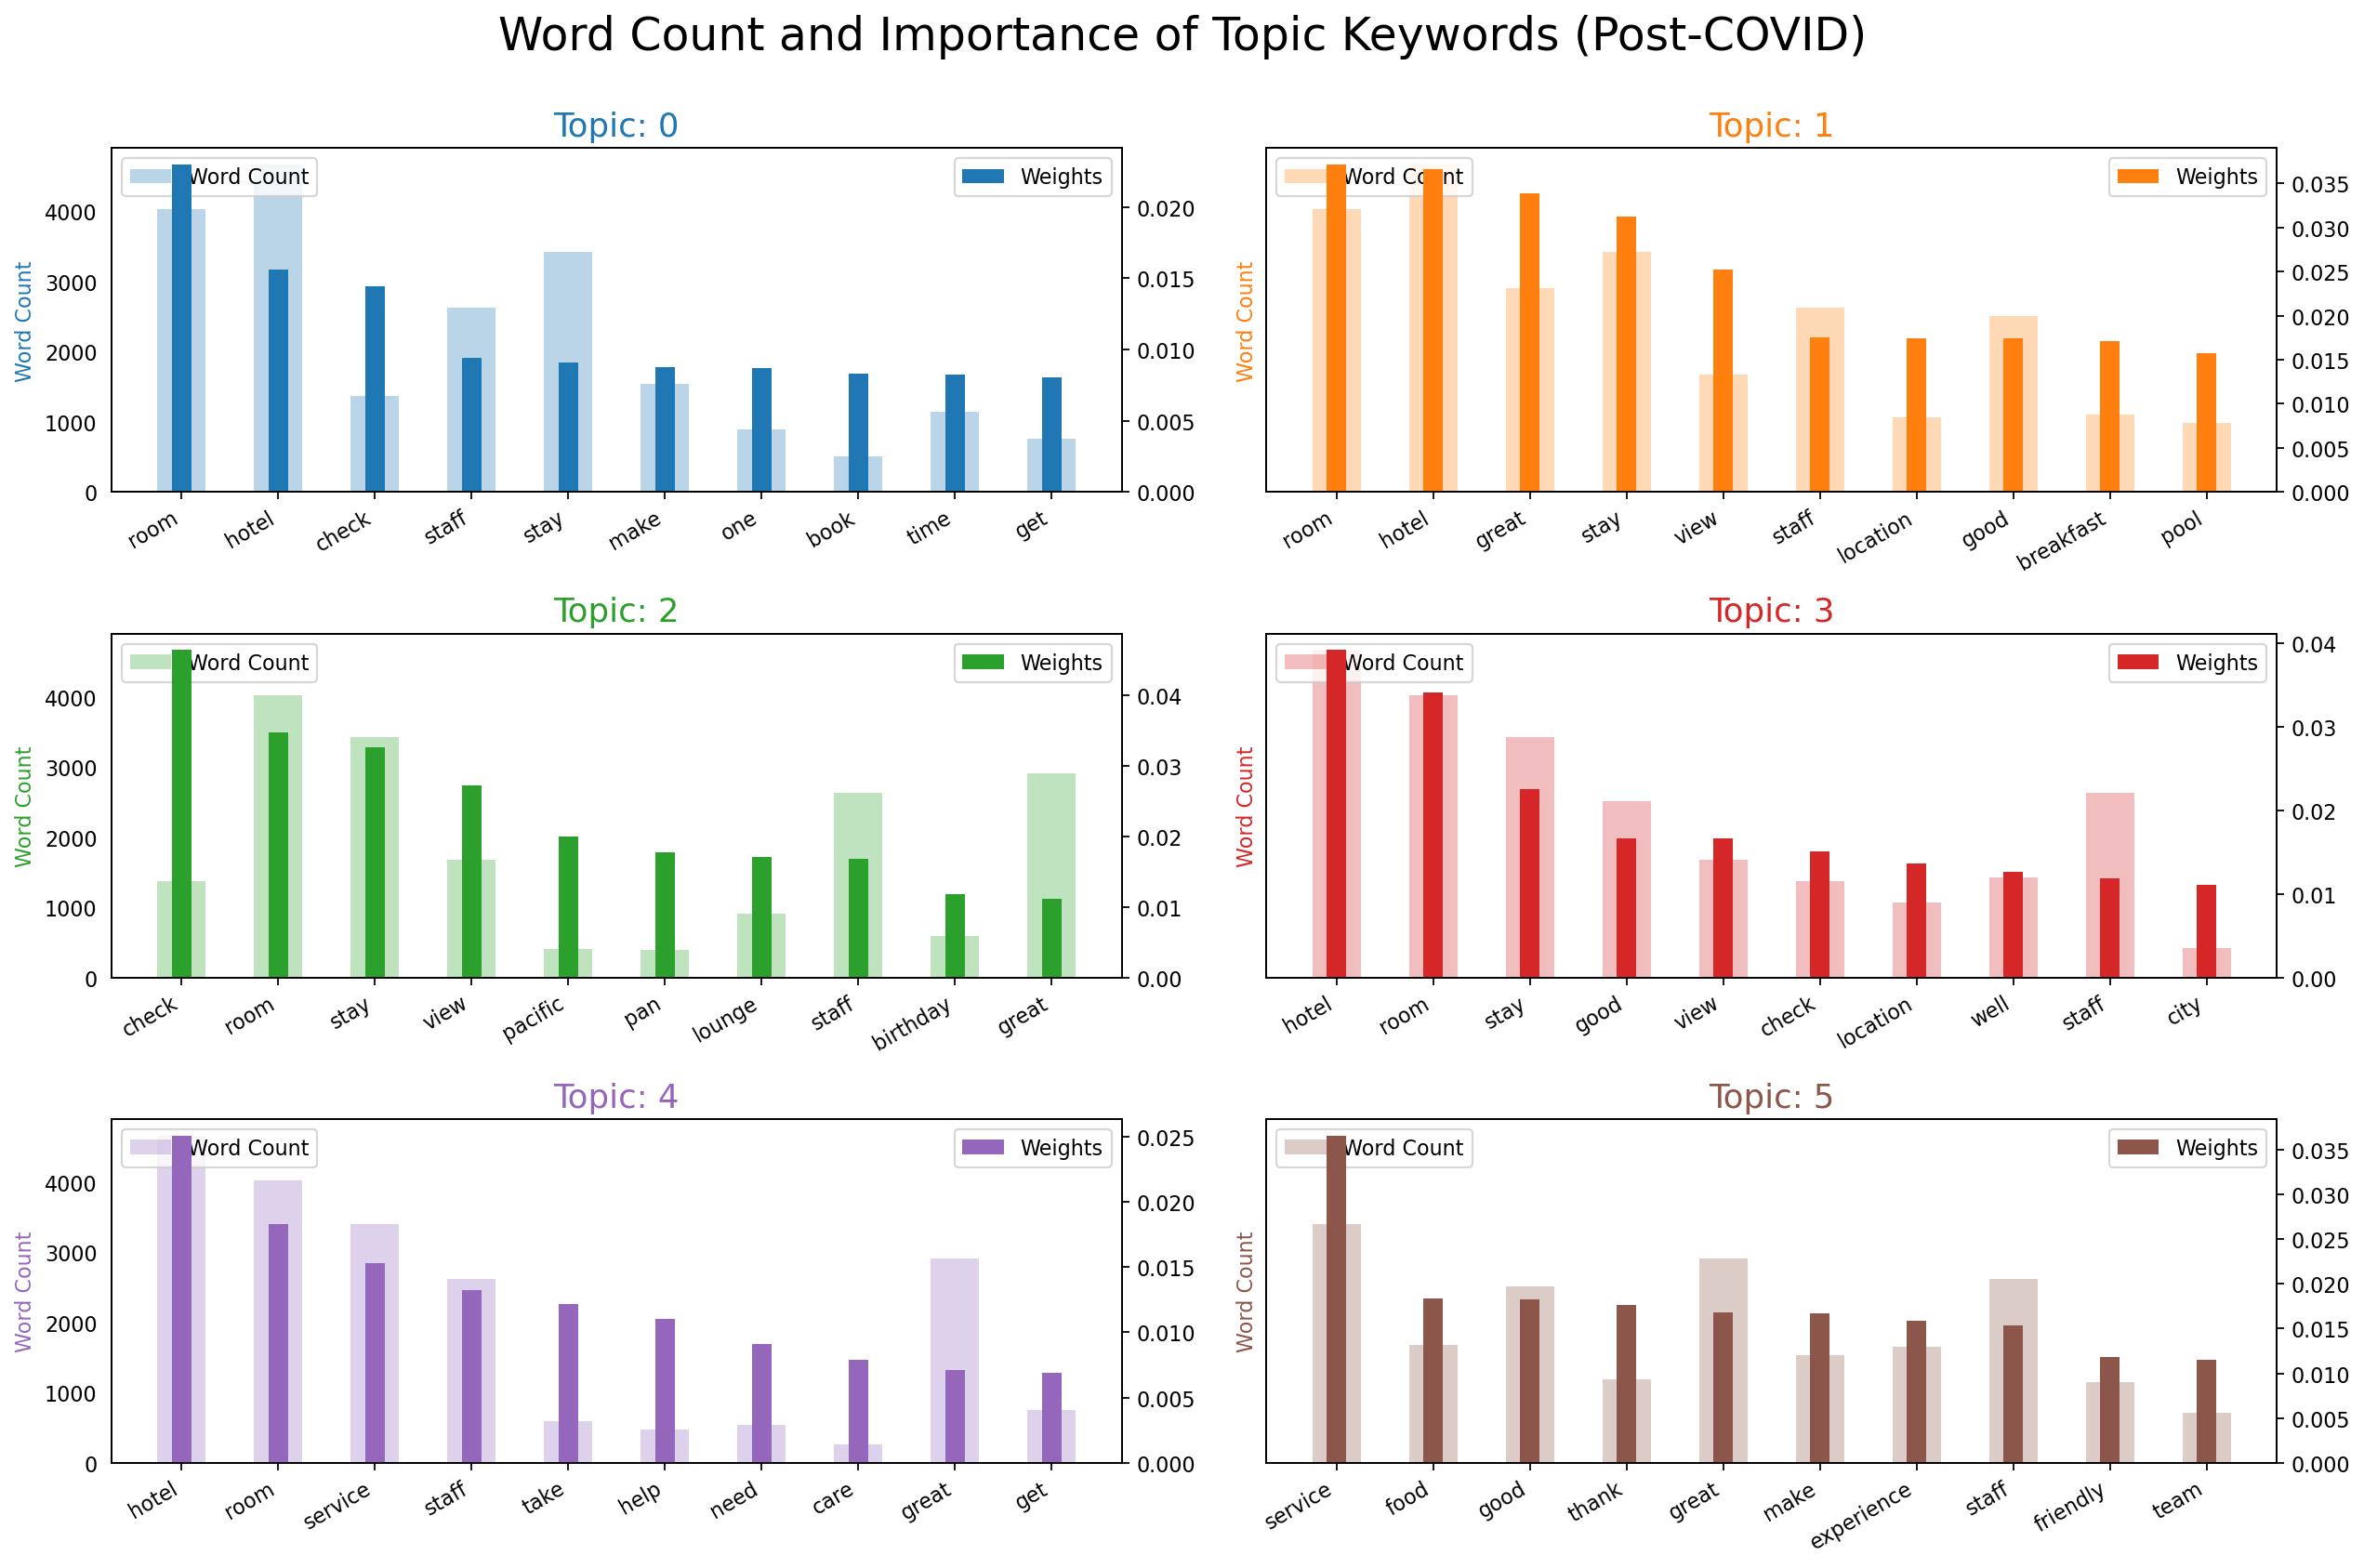

In [42]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

# For Post-COVID
plot_word_count_importance(topics_post, data_flat_post, 'Word Count and Importance of Topic Keywords (Post-COVID)')

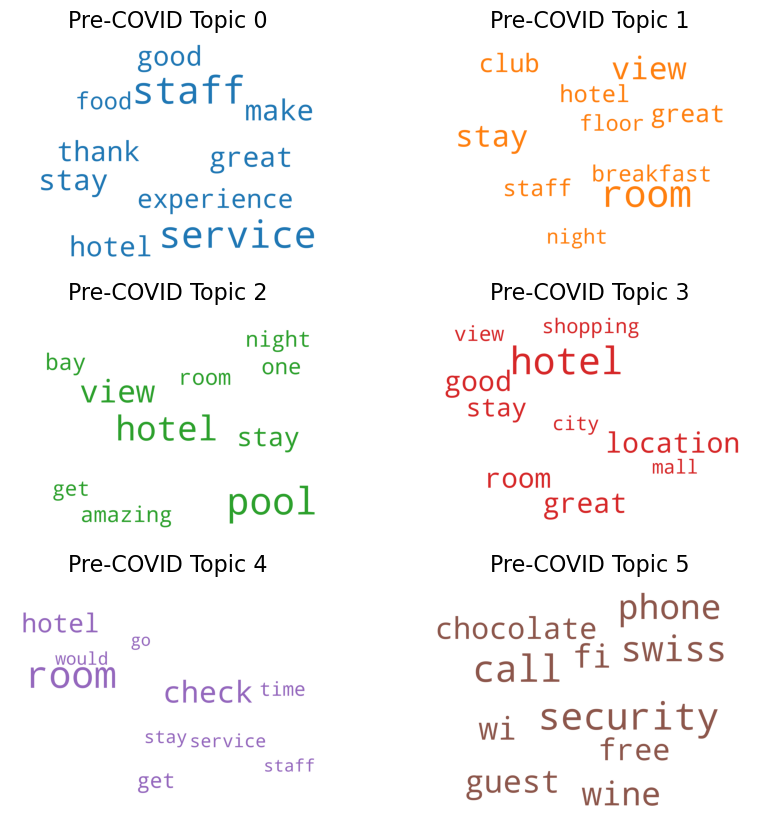

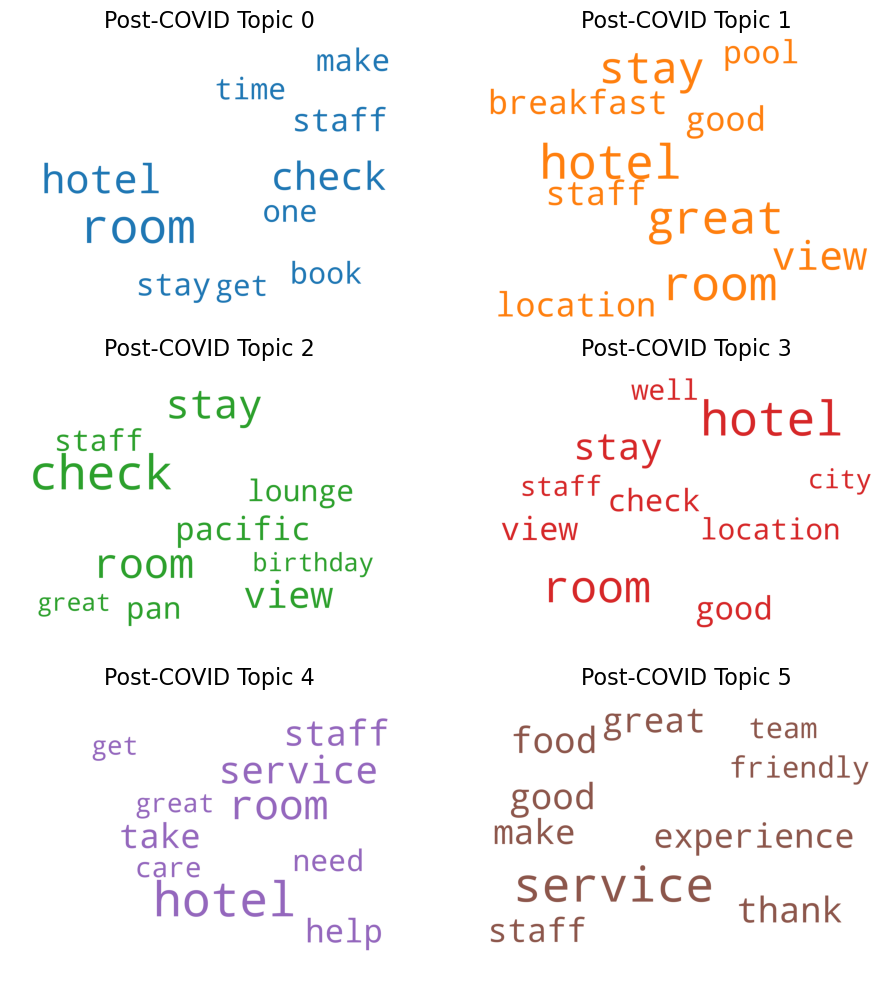

In [43]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [44]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [45]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [46]:
clean_precovid = df_precovid['lem_review'].apply(preprocess)
clean_precovid = clean_precovid.apply(lambda x: ' '.join(x))
clean_postcovid = df_postcovid['lem_review'].apply(preprocess)
clean_postcovid = clean_postcovid.apply(lambda x: ' '.join(x))

In [47]:
from nltk import ngrams
bigrams_precovid = []
bigrams_postcovid = []

for d in clean_precovid:
    tokens = word_tokenize(d)
    bigrams_precovid.append(["_".join(w) for w in ngrams(tokens, 2)])

for e in clean_postcovid:
    tokens = word_tokenize(e)
    bigrams_postcovid.append(['_'.join(w) for w in ngrams(tokens, 2)])


In [48]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_precovid)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_precovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=6, id2word=pre_dict, passes=15)

In [49]:
##Generate LDA dictionary and corpus
post_dict = corpora.Dictionary(bigrams_postcovid)
post_corpus = [post_dict.doc2bow(text) for text in bigrams_postcovid]
## Check optimal number of topics
lda = gensim.models.ldamodel.LdaModel
post_ldamodel = lda(post_corpus, num_topics=6, id2word=post_dict, passes=15)

In [50]:
# For Pre-COVID
topics_pre = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_precovid for word in word_list]

# For Post-COVID
topics_post = post_ldamodel.show_topics(formatted=False)
data_flat_post = [word for word_list in bigrams_postcovid for word in word_list]

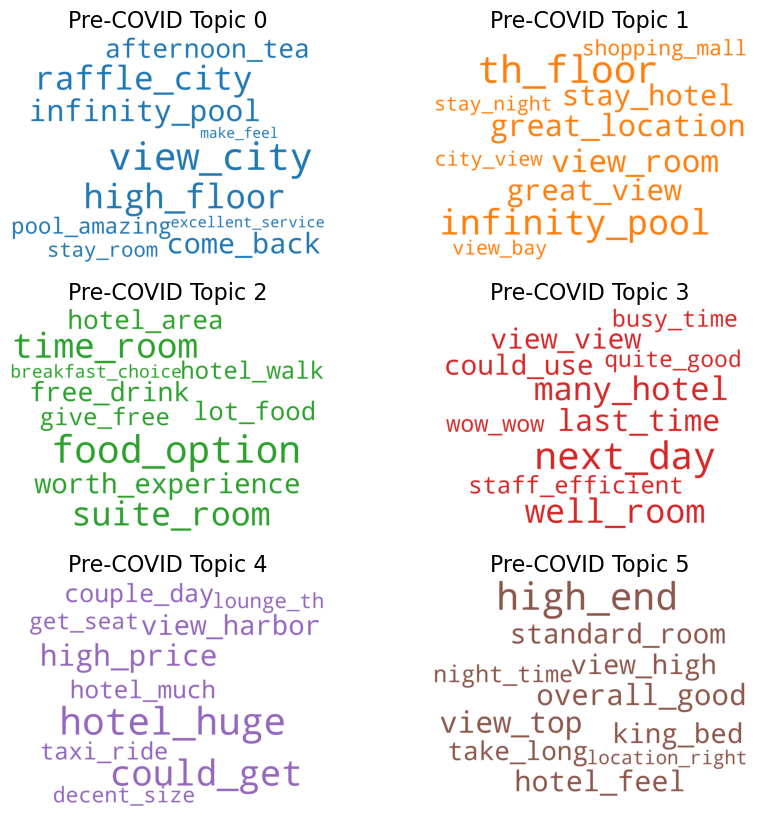

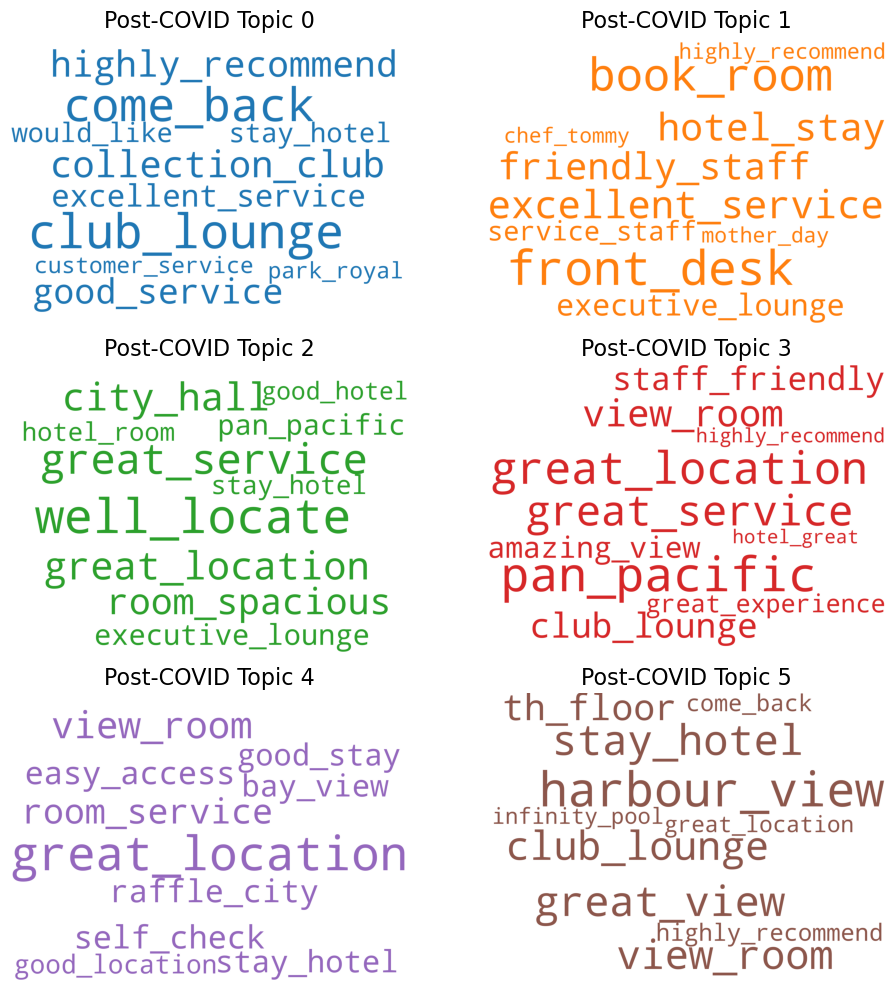

In [51]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Create WordClouds for each topic in the post-COVID dataset
clouds_post = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(post_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_post.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

# Plot the WordClouds for post-COVID topics
fig_post, axes_post = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_post.flatten()):
    fig_post.add_subplot(ax)
    if i < len(clouds_post):
        plt.gca().imshow(clouds_post[i])
        plt.gca().set_title('Post-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [52]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [53]:
vis = pyLDAvis.gensim.prepare(topic_model=post_ldamodel, corpus=post_corpus, dictionary=post_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)


Dependency Parsing

In [20]:
import spacy

In [21]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [22]:
new_dict = restruct_topics(topics_pre)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 14
length topic 1: 13
length topic 2: 10
length topic 3: 17
length topic 4: 17


In [23]:
nlp = spacy.load("en_core_web_sm")

In [36]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [25]:
df_filtered = df_filtered.reset_index()

In [37]:
dep_parse(df_filtered, new_dict)

In [38]:
df_filtered['aspect_sentiment']

0                                                       []
1            [[hotel, Best, 0], [breakfast, delicious, 0]]
2                                        [[stay, nice, 0]]
3         [[place, exclusive, 3], (place, more exclusive)]
4                                        [[time, next, 1]]
                               ...                        
35617    [[stay, recent, 0], (stay, most recent), (hote...
35618    [[view, sensational, 2], [floor, 40th, 2], [vi...
35619    [[view, great, 2], [room, decent, 1], [room, l...
35620                               [[hotel, Ordinary, 0]]
35621    [[floor, 57th, 2], [day, first, 1], [room, sma...
Name: aspect_sentiment, Length: 35622, dtype: object